### Initialization
Installing requirements, auto reload changing to code, imports and some configurations

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# disable tqdm progress bar by default
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

### Define research parameters

In [5]:
regression_task = False
# continuous_features = []
test_size_proportion = 0.2
augment_sample = 0.5
metrics = ['f1_weighted', 'accuracy', 'balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'] 

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

In [6]:
from sklearn.datasets import make_classification

# Define the parameters of the synthetic dataset
n_samples = 600  # Total number of samples
n_features = 12   # Number of features
n_classes = 3    # Number of classes
class_weights = [0.5, 0.2, 0.3]  # Class imbalance ratio

# Create the imbalanced dataset
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features,
                           n_informative=3,
                           n_classes=n_classes,
                           n_clusters_per_class=2,
                           weights=class_weights,
                           class_sep=0.5, # 1
                           random_state=42)
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
y = pd.Series(y, name="target")

In [7]:
continuous_features = X.columns.tolist()

#### split data

In [8]:
# all data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

In [9]:
display(y_train.value_counts())

0    250
2    142
1     88
Name: target, dtype: int64

In [10]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [11]:
print(f'whole adult dataset scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
whole_dataset_result_df

whole adult dataset scores:


whole                                                 \
    f1_weighted  accuracy balanced_accuracy precision_weighted   
lg     0.503221  0.583333          0.508333           0.473485   
rf     0.491908  0.566667          0.492778           0.698689   
xgb    0.609320  0.616667          0.586667           0.629507   

                                                               
    recall_weighted roc_auc_ovr_weighted roc_auc_ovo_weighted  
lg         0.583333             0.711925             0.701726  
rf         0.566667             0.753310             0.745795  
xgb        0.616667             0.763955             0.758604

In [12]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### running experiments

In [13]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             cf_scoring = 'balanced_accuracy',
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
     utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # print(list(s.values())[0])

    full_results_df = pd.concat([full_results_df, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')
print(f'\nTotal time: {time.time() - total_time}')


0 / 4, {'method': 'random'} 13.673442363739014 seconds for settings 0
1 / 4, {'method': 'smote'} 12.469648361206055 seconds for settings 1
2 / 4, {'method': 'cf_random'} model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.5711111111111111}}
0/108
50/108
100/108
0/162
50/162
100/162
150/162
model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.5711111111111111}}
0/240
50/240
100/240
150/240
200/240
485.4006242752075 seconds for settings 2
3 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}} model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.5711111111111111}}
0/108
50/108
100/108
0/162
50/162
100/162
150/162
model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.5711111111111111}}
0/240
50/240
100/240
150/240
200/240
191.59896183013916 seconds for settings 3

Total time: 703.1426768302917


In [14]:
full_results_df

whole                                                 \
    f1_weighted  accuracy balanced_accuracy precision_weighted   
lg     0.503221  0.583333          0.508333           0.473485   
rf     0.491908  0.566667          0.492778           0.698689   
xgb    0.609320  0.616667          0.586667           0.629507   

                                                                   random  \
    recall_weighted roc_auc_ovr_weighted roc_auc_ovo_weighted f1_weighted   
lg         0.583333             0.711925             0.701726    0.502033   
rf         0.566667             0.753310             0.745795    0.518568   
xgb        0.616667             0.763955             0.758604    0.620810   

                                                                    \
     accuracy balanced_accuracy precision_weighted recall_weighted   
lg   0.583333          0.508333           0.468042        0.583333   
rf   0.575000          0.504444           0.647908        0.575000   
xgb  0.625000          0.602222           0.632371        0.625000   

                                                    smote            \
    roc_auc_ovr_weighted roc_auc_ovo_weighted f1_weighted  accuracy   
lg              0.709737             0.700104    0.535022  0.533333   
rf              0.758631             0.753972    0.584567  0.583333   
xgb             0.777409             0.776844    0.583607  0.583333   

                                                                               \
    balanced_accuracy precision_weighted recall_weighted roc_auc_ovr_weighted   
lg           0.518333           0.537171        0.533333             0.712736   
rf           0.580556           0.587963        0.583333             0.762563   
xgb          0.583333           0.586057        0.583333             0.773006   

                           cf_random                              \
    roc_auc_ovo_weighted f1_weighted  accuracy balanced_accuracy   
lg              0.703260    0.537460  0.541667          0.536667   
rf              0.761392    0.586830  0.591667          0.567222   
xgb             0.778132    0.615001  0.616667          0.598333   

                                                             \
    precision_weighted recall_weighted roc_auc_ovr_weighted   
lg            0.583333        0.541667             0.735865   
rf            0.622987        0.591667             0.743953   
xgb           0.623512        0.616667             0.781300   

                          cf_genetic                              \
    roc_auc_ovo_weighted f1_weighted  accuracy balanced_accuracy   
lg              0.728493    0.517778  0.600000          0.525000   
rf              0.736306    0.559882  0.608333          0.547778   
xgb             0.780875    0.639195  0.641667          0.622778   

                                                             \
    precision_weighted recall_weighted roc_auc_ovr_weighted   
lg            0.477731        0.600000             0.696093   
rf            0.702412        0.608333             0.766832   
xgb           0.654708        0.641667             0.758644   

                          
    roc_auc_ovo_weighted  
lg              0.686722  
rf              0.760885  
xgb             0.778531

In [15]:
print('best methods:')
display(utils.get_best_methods(full_results_df))

best methods:


,f1_weighted,accuracy,balanced_accuracy,precision_weighted,recall_weighted,roc_auc_ovr_weighted,roc_auc_ovo_weighted
lg,cf_random,cf_genetic,cf_random,cf_random,cf_genetic,cf_random,cf_random
rf,cf_random,cf_genetic,smote,cf_genetic,cf_genetic,cf_genetic,smote
xgb,cf_genetic,cf_genetic,cf_genetic,cf_genetic,cf_genetic,cf_random,cf_random
overall,cf_genetic,cf_genetic,cf_genetic,cf_genetic,cf_genetic,cf_random,cf_random


In [16]:
utils.save_results_as_latex_tables(full_results_df, task_name="artifical")

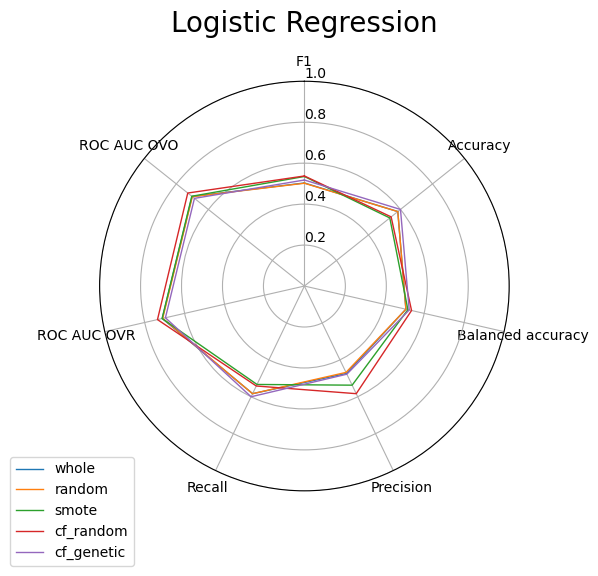

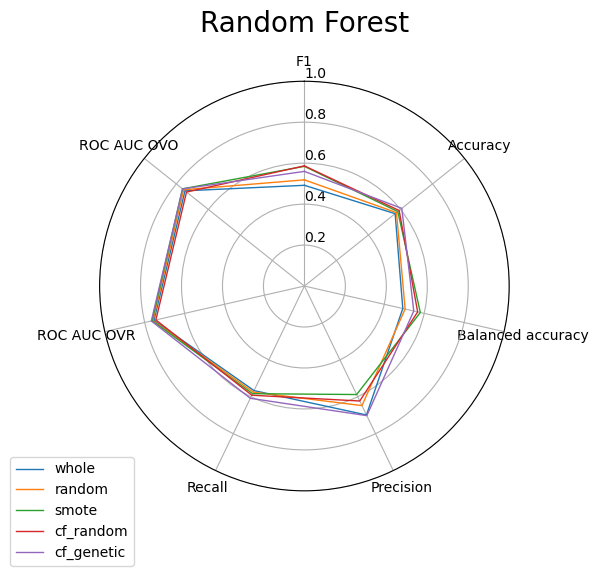

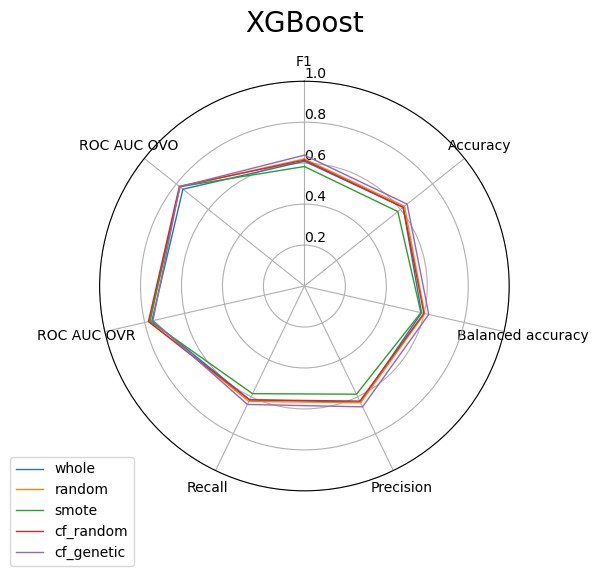

In [17]:
wanted_cols = ['whole', 'random','smote','cf_random','cf_genetic']
metric_names = {'f1_weighted': 'F1',
                'accuracy': 'Accuracy',
                'balanced_accuracy': 'Balanced accuracy',
                'precision_weighted': 'Precision',
                'recall_weighted': 'Recall',
                'roc_auc_ovr_weighted': 'ROC AUC OVR',
                'roc_auc_ovo_weighted': 'ROC AUC OVO'}
utils.spider_plot(full_results_df, 'lg', wanted_cols, metric_names, 'Logistic Regression', save_task_name='artifical')
utils.spider_plot(full_results_df, 'rf', wanted_cols, metric_names, 'Random Forest', save_task_name='artifical')
utils.spider_plot(full_results_df, 'xgb', wanted_cols, metric_names, 'XGBoost', save_task_name='artifical')

In [18]:
full_results_df.to_csv(rf'../log/experiment_multiclass_artifical.csv')